In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#parameters
random_seed = 42
learning_rate = 0.001
batch_size_train = 256
batch_size_test = 1000
n_epochs = 10

img_size = 32

In [ ]:

def train(model, train_loader, optimizer, loss_func, device):
  '''
  training step
  '''

  model.train()
  running_loss = 0
  num_correct_pred = 0

  for X, y_true in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, y_hat_probs = model(X)

    loss = loss_func(y_hat, y_true)

    pred_labels = torch.argmax(y_hat_probs, 1)
    num_correct_pred += (pred_labels == y_true).sum()

    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_accuracy = num_correct_pred / len(train_loader.dataset)
  return model, optimizer, epoch_loss, epoch_accuracy

In [ ]:
def test(model, test_loader, loss_fun, device):
  '''
  test iteration
  '''

  model.eval()
  running_loss = 0
  num_correct_pred = 0

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, y_hat_probs = model(X)

    loss = loss_func(y_hat, y_true)

    pred_labels = torch.argmax(y_hat_probs, 1)
    num_correct_pred += (pred_labels == y_true).sum()

    running_loss += loss.item() * X.size(0)
  
  epoch_loss = running_loss / len(test_loader.dataset)
  epoch_accuracy = num_correct_pred / len(test_loader.dataset)
  return model, epoch_loss, epoch_accuracy

In [ ]:
def training_loop(model, train_loader, test_loader, loss_func, optimizer, epochs, device):

  train_losses = []
  test_losses = []

  for epoch in tqdm(range(epochs), desc='Epoch'):
    model, optimizer, train_loss, train_accuracy = train(model, train_loader, optimizer, loss_func, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, test_loss, test_accuracy = test(model, test_loader, loss_func, device)
      test_losses.append(test_loss)

    print(f'train loss:{train_loss:.4f} test_loss:{test_loss:.4f} train_accuracy:{train_accuracy * 100:.2f}% test_accuracy:{test_accuracy * 100:.2f}%')

  return model, optimizer, train_losses, test_losses

In [ ]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081))])
train_data = datasets.MNIST('./data', train=True, download=True, transform=tf)
test_data = datasets.MNIST('./data', train=False, download=True, transform=tf)

train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 86928100.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82237402.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33291091.73it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21550371.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
    self.subs1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.subs2 = nn.MaxPool2d(2)
    self.dr1 = nn.Dropout(0.5)
    self.fc1= nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 84)
    self.dr2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.subs1(x)
    x = F.relu(self.conv2(x))
    x = self.subs2(x)
    x = self.dr1(x)
    x = x.view(-1, np.prod(x.size()[1:]))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dr2(x)
    logits = self.fc3(x)
    probabilities = F.softmax(logits, dim=1)
    return logits, probabilities

In [ ]:
model = LeNet().to(device)
optimizer = optim.Adadelta(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
list(model.children())[-3]

[Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=400, out_features=120, bias=True),
 Linear(in_features=120, out_features=84, bias=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=84, out_features=10, bias=True)]

In [ ]:
model, optimizer, train_losses, test_losses = training_loop(model, train_loader, test_loader, loss_func, optimizer, n_epochs, device)

Epoch:  10%|█         | 1/10 [00:28<04:16, 28.53s/it]

train loss:0.4957 test_loss:0.0882 train_accuracy:84.36% test_accuracy:97.34%


Epoch:  20%|██        | 2/10 [00:43<02:45, 20.65s/it]

train loss:0.1686 test_loss:0.0651 train_accuracy:95.18% test_accuracy:98.03%


Epoch:  30%|███       | 3/10 [00:59<02:08, 18.34s/it]

train loss:0.1290 test_loss:0.0502 train_accuracy:96.38% test_accuracy:98.44%


Epoch:  40%|████      | 4/10 [01:14<01:42, 17.04s/it]

train loss:0.1123 test_loss:0.0449 train_accuracy:96.88% test_accuracy:98.55%


Epoch:  50%|█████     | 5/10 [01:30<01:23, 16.65s/it]

train loss:0.0987 test_loss:0.0427 train_accuracy:97.24% test_accuracy:98.70%


Epoch:  60%|██████    | 6/10 [01:45<01:04, 16.23s/it]

train loss:0.0895 test_loss:0.0432 train_accuracy:97.46% test_accuracy:98.67%


Epoch:  70%|███████   | 7/10 [02:01<00:47, 15.98s/it]

train loss:0.0831 test_loss:0.0345 train_accuracy:97.72% test_accuracy:98.95%


Epoch:  80%|████████  | 8/10 [02:16<00:31, 15.72s/it]

train loss:0.0789 test_loss:0.0342 train_accuracy:97.81% test_accuracy:99.05%


Epoch:  90%|█████████ | 9/10 [02:31<00:15, 15.41s/it]

train loss:0.0721 test_loss:0.0353 train_accuracy:98.07% test_accuracy:98.97%


Epoch: 100%|██████████| 10/10 [02:45<00:00, 16.60s/it]

train loss:0.0714 test_loss:0.0323 train_accuracy:98.06% test_accuracy:99.03%


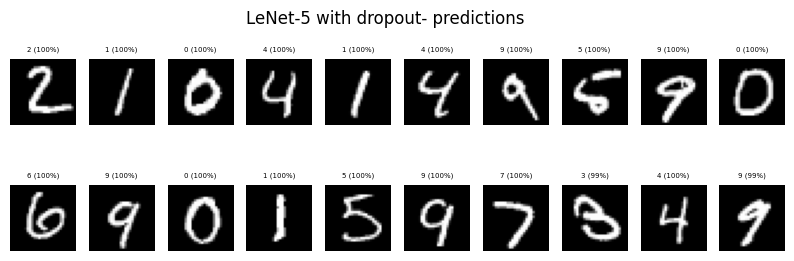

In [ ]:
n_cols = 10
n_rows = 2

fig = plt.figure(figsize=(10, 3))
for index in range(1, n_cols * n_rows + 1):
    plt.subplot(n_rows, n_cols, index)
    plt.axis('off')
    plt.imshow(test_data.data[index], cmap='gray')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_data[index][0].unsqueeze(0).to(device))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=5)
fig.suptitle('LeNet-5 with dropout- predictions');

In [ ]:
torch.save(model.state_dict(), 'LeNetDrout.pt')